In [1]:
import sympy
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import re
import optax
import jax
import distrax


from sympy.parsing.sympy_parser import parse_expr
from sympy.printing import pycode
from functools import partial
from flax import linen as nn
from random import random
from tqdm.auto import tqdm
from jax import jit
from typing import Callable

key = jax.random.PRNGKey(1)

In [415]:
def process_system(sys_desc: str, params_desc: str, action_desc: str, exclude_desc: str) -> str:
    sym_sorted = lambda x: sorted(x, key=lambda s: s.name)

    eqs = parse_expr(', '.join(sys_desc.split('\n')[1:-1]), evaluate=False)
    eqs_ = eqs

    variables = set.union(*(eq.free_symbols for eq in eqs))
    param_vars = set(parse_expr(params_desc))
    action_vars = set(parse_expr(action_desc))
    exclude_vars = set(parse_expr(exclude_desc)) if len(exclude_desc) > 0 else set()
    prev_vars = set(filter(lambda v: "_prev" in v.name, variables))
    state_vars = variables ^ (param_vars | action_vars | prev_vars)

    print(state_vars)
    print(len(state_vars))
    print(len(eqs))

    sys = sympy.solve(eqs, state_vars, manual=True, warn=True, check=False, simplify=False)
    if type(sys) == list:
        assert len(sys) == 1, str(len(sys))
        sys = sys[0]

    sys = {sym: formula for sym, formula in sys.items() if sym not in exclude_vars}
    state_vars ^= exclude_vars

    keys = sys.keys()
    tmp, sys = sympy.cse(sys.values(), order='none')
    sys = zip(keys, sys)

    code = "@jit\ndef update(state: jnp.ndarray, action: jnp.ndarray, params: jnp.ndarray):\n"
    code += "\t" + ", ".join(map(lambda s: f"{str(s)}_prev", sym_sorted(state_vars))) + ", = state.T\n"
    code += "\t" + str(sym_sorted(action_vars))[1:-1] + ", = action.T\n"
    code += "\t" + str(sym_sorted(param_vars))[1:-1] + ", = params\n\n"

    for a in (tmp, sys):
        for l, r in a:
            code += "\t" + f"{pycode(l)} = {pycode(r)}\n"
        code += '\n'
    code += "\t" + f"return jnp.array([{str(sym_sorted(state_vars))[1:-1]}]).T\n"

    update_code = code

    sys_desc = sys_desc.replace("_prev", "")
    eqs = parse_expr(', '.join(sys_desc.split('\n')[1:-1]), evaluate=False)

    variables = set.union(*(eq.free_symbols for eq in eqs))
    state_vars = variables ^ (param_vars | action_vars)

    n_free_vars = max(0, len(state_vars) - len(eqs))
    free_vars = set(list(state_vars)[:n_free_vars])
    derivable_vars = set(list(state_vars)[n_free_vars:])

    sys = sympy.solve(eqs, derivable_vars)
    if type(sys) == list:
        assert len(sys) == 1
        sys = sys[0]
    
    sys = {sym: formula for sym, formula in sys.items() if sym not in exclude_vars}
    state_vars ^= exclude_vars

    free_vars = free_vars | (set(sys.keys()) ^ state_vars)

    keys = sys.keys()
    tmp, sys = sympy.cse(sys.values(), order='none')
    sys = zip(keys, sys)    

    code = "@partial(jit, static_argnames=['n_states'])\ndef sample_stable_state(action: jnp.ndarray, params: jnp.ndarray, n_states: int, seed: jnp.ndarray):\n"
    code += "\t" + str(sym_sorted(action_vars))[1:-1] + ", = action.T\n"
    code += "\t" + str(sym_sorted(param_vars))[1:-1] + ", = params\n\n"
    code += "\t" + str(sym_sorted(free_vars))[1:-1] + f", = jax.random.uniform(seed, ({len(free_vars)}, n_states), minval=0.0, maxval=1.0)\n\n"

    for a in (tmp, sys):
        for l, r in a:
            code += "\t" + f"{pycode(l)} = {pycode(r)}\n"
        code += '\n'
    code += "\t" + f"return jnp.array([{str(sym_sorted(state_vars))[1:-1]}]).T\n"

    stable_state_code = code

    return {
        "update_code": update_code,
        "stable_state_code": stable_state_code,
        "state_vars": str(sym_sorted(state_vars))[1:-1].split(', '),
        "action_vars": str(sym_sorted(action_vars))[1:-1].split(', '),
        "params": str(sym_sorted(param_vars))[1:-1].split(', '),
        "equations": eqs_,
    }


In [416]:
SIM = {
    "sys_desc": '''
YD == W * N_s - T
T == theta * W * N_s
C == alpha_1 * YD + alpha_2 * H_h_prev
dH_s == H_s - H_s_prev
dH_s == G - T
dH_h == H_h - H_h_prev
dH_h == YD - C
Y == C + G
N_s == Y / W
dH_h == dH_s
''',
    "params_desc": "alpha_1, alpha_2, W,",
    "action_desc": "G, theta,",
    "exclude_desc": "dH_h, dH_s,",
}

SIMEX = {
    "sys_desc": '''
YD == W * N_s - T
T == theta * W * N_s
C == alpha_1 * YD_e + alpha_2 * H_h_prev
dH_s == H_s - H_s_prev
dH_s == G - T
dH_h == H_h - H_h_prev
dH_h == YD - C
Y == C + G
N_s == Y / W
dH_d == H_d - H_h_prev
dH_d == YD_e - C
YD_e == YD_prev
dH_h == dH_s
''',
    "params_desc": "alpha_1, alpha_2, W,",
    "action_desc": "G, theta,",
    "exclude_desc": "dH_h, dH_s, dH_d,",
}

PC = {
    "sys_desc": '''
Y == C + G
YD == Y - T + r_prev * B_h_prev
T == theta * (Y + r_prev * B_h_prev)
V == V_prev + YD - C
C == alpha_1 * YD + alpha_2 * V_prev
H_h == V - B_h
B_h / V == lambda_0 + lambda_1 * r - lambda_2 * YD / V
dB_s == B_s - B_s_prev
dB_s == G + r_prev * B_s_prev - T - r_prev * B_cb_prev
dH_s == H_s - H_s_prev
dH_s == dB_cb
B_cb == B_s - B_h
dB_cb == B_cb - B_cb_prev
r == r_cap
''',
    "params_desc": "alpha_1, alpha_2, lambda_0, lambda_1, lambda_2,",
    "action_desc": "G, r_cap, theta,",
    "exclude_desc": "dB_s, dH_s, dB_cb,",
}

PCEX_deterministic = {
    "sys_desc": '''
Y == C + G
YD == Y - T + r_prev * B_h_prev
T == theta * (Y + r_prev * B_h_prev)
V == V_prev + YD - C
C == alpha_1 * YD_e + alpha_2 * V_prev
B_d / V_e == lambda_0 + lambda_1 * r - lambda_2 * YD_e / V_e
H_d / V_e == 1 - lambda_0 - lambda_1 * r + lambda_2 * YD_e / V_e
H_d == V_e - B_d
V_e == V_prev + YD_e - C
H_h == V - B_h
B_h == B_d
dB_s == B_s - B_s_prev
dB_s == G + r_prev * B_s_prev - T - r_prev * B_cb_prev
dH_s == H_s - H_s_prev
dH_s == dB_cb
dB_cb == B_cb - B_cb_prev
B_cb == B_s - B_h
r == r_cap
YD_e == YD_prev
''',
    "params_desc": "alpha_1, alpha_2, lambda_0, lambda_1, lambda_2,",
    "action_desc": "G, r_cap, theta,",
    "exclude_desc": "dB_s, dH_s, dB_cb,",
}

# H_d / V_e == lambda_10 + lambda_12 * r_b + lambda_13 * ERr_bL + lambda_14 * YD_r_e / V_e
LP = {
    "sys_desc": '''
Y == C + G
YD_r == Y - T + r_b_prev * B_h_prev + BL_h_prev
T == theta * (Y * r_b_prev * B_h_prev + BL_h_prev)
V == V_prev + YD_r - C + CG
CG == dp_bL * BL_h_prev
C == alpha_1 * YD_r_e + alpha_2 * V_prev
V_e == V_prev + YD_r_e - C + CG_e
H_h == V - B_h - p_bL * BL_h
H_d == V_e - B_d - p_bL * BL_d
B_d / V_e == lambda_20 + lambda_22 * r_b + lambda_23 * ERr_bL + lambda_24 * YD_r_e / V_e
BL_d * p_bL / V_e == lambda_30 + lambda_32 * r_b + lambda_33 * ERr_bL + lambda_34 * YD_r_e / V_e
B_h == B_d
BL_h == BL_d
dB_s == B_s - B_s_prev
dB_s == G + r_b_prev * B_s_prev + BL_s_prev - T - r_b_prev * B_cb_prev - dBL_s * p_bL
dH_s == H_s - H_s_prev
dH_s == dB_cb
dB_cb == B_cb - B_cb_prev
B_cb == B_s - B_h
BL_s == BL_h
ERr_bL == r_bL + cappa * (p_bL_e - p_bL) / p_bL
r_bL == 1 / p_bL
p_bL_e == p_bL
CG_e == cappa * (p_bL_e - p_bL) * BL_h
YD_r_e == YD_r_prev
r_b == r_b_cap
p_bL == p_bL_cap
dp_bL == p_bL - p_bL_prev
dBL_s == BL_s - BL_s_prev
''',
    "params_desc": "alpha_1, alpha_2, theta, lambda_20, lambda_22, lambda_23, lambda_24, lambda_30, lambda_32, lambda_33, lambda_34, cappa,",
    "action_desc": "G, r_b_cap, p_bL_cap,",
    "exclude_desc": "dB_s, dH_s, dB_cb, dBL_s, dp_bL",
}

systems = {
    "SIM": {
        "args": SIM,
        "params": { # TODO: generate params randomly as  bigger models have a lot of ones
            "alpha_1": 0.1,
            "alpha_2": 0.2,
            "W": 0.05,
        },
    },
    "SIMEX": {
        "args": SIMEX,
        "params": {
            "alpha_1": 0.1,
            "alpha_2": 0.2,
            "W": 0.05,
        },
    },
    "PC": {
        "args": PC,
        "params": {
            "alpha_1": 0.1,
            "alpha_2": 0.2,
            "lambda_0": 0.1,
            "lambda_1": 0.2,
            "lambda_2": 0.3,
        },
    },
    "PCEX_deterministic": {
        "args": PCEX_deterministic,
        "params": {
            "alpha_1": 0.1,
            "alpha_2": 0.2,
            "lambda_0": 0.1,
            "lambda_1": 0.2,
            "lambda_2": 0.3,
        },
    }
}


# LP = {
#     "sys_desc": '''
# Y == C + G
# YD_r == Y - T + r_b_prev * B_h_prev + BL_h_prev
# T == theta * (Y + r_b_prev * B_h_prev + BL_h_prev)
# V == V_prev + YD_r - C + CG
# CG == dp_bL * BL_h_prev
# С == alpha_1 * YD_r_e + alpha_2 * V_prev
# V_e == V_prev + YD_r_e - C + CG_e
# H_h == V - B_h - p_bL * BL_d
# H_d == V_e - B_d - p_bL * BL_d
# H_d / V_e == lambda_10 + lambda_12 * r_b + lambda_13 * ERr_bL + lambda_14 * YD_r_e / V_e
# B_d / V_e == lambda_20 + lambda_22 * r_b + lambda_23 * ERr_bL + lambda_24 * YD_r_e / V_e
# BL_d * p_bL / V_e == lambda_30 + lambda_32 * r_b + lambda_33 * ERr_bL + lambda_34 * YD_r_e / V_e
# B_h == B_d
# BL_h == BL_d
# dB_s == B_s - B_s_prev
# dB_s == G + r_b_prev * B_s_prev + BL_s_prev - T - r_b_prev * B_cb_prev - dBL_s * p_bL
# dH_s == H_s - H_s_prev
# B_cb == B_s - B_h
# dB_cb == B_cb - B_cb_prev
# dB_cb == dH_s
# BL_s == BL_h
# ERr_bL == r_bL + cappa * (p_bL_e - p_bL) / p_bL
# r_bL == 1 / p_bL
# p_bL_e == p_bL
# CG_e == cappa * (p_bL_e - p_bL) * BL_h
# YD_r_e == YD_r_prev
# r_b == r_b_cap
# p_bL == p_bL_cap
# H_s == H_h
# dBL_s == BL_s - BL_s_prev
# dp_bL == p_bL - p_bL_prev
# ''',
#     "params_desc": "alpha_1, alpha_2, theta, lambda_10, lambda_12, lambda_13, lambda_14, lambda_20, lambda_22, lambda_23, lambda_24, lambda_30, lambda_32, lambda_33, lambda_34, cappa,",
#     "action_desc": "G, r_b_cap, p_bL_cap,",
#     "exclude_desc": "dB_s, dH_s, dB_cb, dBL_s, dp_bL",
# }

In [ ]:
%%time
process_system(**LP)

{B_s, Y, BL_d, ERr_bL, p_bL_e, dH_s, YD_r_e, BL_s, dB_s, dp_bL, C, CG_e, T, YD_r, BL_h, p_bL, dBL_s, V, B_d, dB_cb, B_h, B_cb, r_bL, H_h, V_e, r_b, H_s, H_d, CG}
29
29


In [96]:
system_info = systems["PC"]
system_data = process_system(**system_info["args"])

In [97]:
state_dim = len(system_data["state_vars"])
action_dim = len(system_data["action_vars"])
system_params = jnp.array([system_info["params"][k] for k in system_data["params"]])

In [98]:
print(system_data["update_code"])
exec(system_data["update_code"])

@jit
def update(state: jnp.ndarray, action: jnp.ndarray, params: jnp.ndarray):
	B_cb_prev, B_h_prev, B_s_prev, C_prev, H_h_prev, H_s_prev, T_prev, V_prev, Y_prev, YD_prev, r_prev, = state.T
	G, r_cap, theta, = action.T
	alpha_1, alpha_2, lambda_0, lambda_1, lambda_2, = params

	x0 = alpha_1*theta
	x1 = 1/(-alpha_1 + x0 + 1)
	x2 = B_cb_prev*r_prev
	x3 = B_s_prev*alpha_1
	x4 = B_s_prev*r_prev
	x5 = G*alpha_1
	x6 = G*x0
	x7 = x5 - x6
	x8 = G*theta
	x9 = B_h_prev*r_prev
	x10 = theta*x9
	x11 = V_prev*alpha_2
	x12 = theta*x11
	x13 = -G + x10 + x12 + x8
	x14 = -B_s_prev*x0 - B_s_prev - alpha_1*x2 + r_prev*x3 + x0*x2 - x0*x4 + x13 + x2 + x3 - x4 + x7
	x15 = G*lambda_0
	x16 = V_prev*lambda_0
	x17 = lambda_0*x9
	x18 = lambda_1*r_cap
	x19 = G*x18
	x20 = V_prev*x18
	x21 = x18*x9
	x22 = V_prev*alpha_1
	x23 = alpha_1*x9
	x24 = -G*lambda_2 - alpha_1*x16 - alpha_1*x17 - alpha_2*theta*x16 - lambda_0*x5 + lambda_2*x10 - lambda_2*x11 + lambda_2*x12 + lambda_2*x8 - lambda_2*x9 - theta*x15 - theta*x17 + x0

In [99]:
print(system_data["stable_state_code"])
exec(system_data["stable_state_code"])

@partial(jit, static_argnames=['n_states'])
def sample_stable_state(action: jnp.ndarray, params: jnp.ndarray, n_states: int, seed: jnp.ndarray):
	G, r_cap, theta, = action.T
	alpha_1, alpha_2, lambda_0, lambda_1, lambda_2, = params

	B_s, H_s, = jax.random.uniform(seed, (2, n_states), minval=0.0, maxval=1.0)

	x0 = alpha_2*theta
	x1 = lambda_0*r_cap
	x2 = lambda_1*r_cap**2
	x3 = alpha_1*x1
	x4 = alpha_1*x2
	x5 = alpha_2*lambda_2
	x6 = -lambda_2*r_cap*x0 + r_cap*x5 + theta*x1 + theta*x2 - theta*x3 - theta*x4 + x0 - x1 - x2 + x3 + x4
	x7 = 1/x6
	x8 = G*(theta - 1)
	x9 = x8*(alpha_1 - 1)
	x10 = lambda_1*r_cap
	x11 = alpha_1*lambda_0 + alpha_1*x10 - lambda_0 - x10 + x5
	x12 = x8*(-alpha_1 + x11 + 1)
	x13 = x7*x8
	x14 = -alpha_2*x8/x6

	B_cb = x7*(B_s*x6 - x12 - x9)
	B_h = x11*x13
	C = x14
	H_h = -x12*x7
	T = G*x0*x7
	V = x7*x9
	Y = G - alpha_2*x13
	YD = x14
	r = r_cap

	return jnp.array([B_cb, B_h, B_s, C, H_h, H_s, T, V, Y, YD, r]).T



In [179]:
@partial(jit, static_argnames=["transforms"])
def transform_action(raw_action: jnp.ndarray, transforms: tuple) -> jnp.ndarray:
    assert raw_action.shape[1] == len(transforms)
    return jnp.stack([transforms[i](raw_action[:, i]) for i in range(len(transforms))], axis=1)

@partial(jit, static_argnames=["transforms"])
def sample_action(mu: jnp.ndarray, sigma: float, seed: jnp.ndarray, transforms: tuple) -> jnp.ndarray:
    act, log_prob = distrax.Normal(mu, sigma).sample_and_log_prob(seed=seed)
    return transform_action(act, transforms), log_prob.sum(axis=1)

In [273]:
system_data["state_vars"]

['B_cb', 'B_h', 'B_s', 'C', 'H_h', 'H_s', 'T', 'V', 'Y', 'YD', 'r']

In [180]:
system_data["state_vars"].index("Y")

8

In [347]:
from typing import Callable

def sample_episode_from_state(sample_action: Callable, params: dict, cost: Callable, initial_state: jnp.ndarray, n_steps: int, key: jnp.ndarray):
    states = []
    actions = []
    costs = []
    log_probs = []

    key, subkey = jax.random.split(key)
    state = initial_state
    for i in tqdm(range(n_steps), desc="Steps", leave=False):
        key, subkey = jax.random.split(key)
        act, log_prob = sample_action(params, state, subkey)

        states.append(state)
        actions.append(act)
        log_probs.append(log_prob)

        state = update(state, act, system_params)
        r = cost(state)
        costs.append(r)

    return jnp.stack(states, axis=1), jnp.stack(actions, axis=1), jnp.stack(costs, axis=1), jnp.stack(log_probs, axis=1)

# TODO: tracer stucks before return, investigate!
# @partial(jit, static_argnames=['sample_action', 'cost', 'n_episodes', 'n_steps'])
def sample_episode(sample_action: Callable, cost: Callable, n_episodes: int, n_steps: int, key: jnp.ndarray):
    key, subkey = jax.random.split(key)
    initial_state = sample_stable_state(alpha_1, alpha_2, theta, n_episodes, subkey)
    return sample_episode_from_state(sample_action, cost, initial_state, n_steps, key)

@jit
def pg_surrogate_objective(costs: jnp.ndarray, log_probs: jnp.ndarray) -> jnp.ndarray:
    tail_costs = jnp.cumsum(costs[:,::-1], axis=1)[:,::-1]
    return (tail_costs * log_probs).mean()

def sample_and_objective_from_state(
    params: dict, 
    initial_state: jnp.ndarray,
    sampler: Callable,
    cost: Callable,
    n_steps: int,
    seed: jnp.ndarray,
) -> jnp.ndarray:
    states, actions, costs, log_probs = sample_episode_from_state(sampler, params, cost, initial_state, n_steps, seed)
    return pg_surrogate_objective(costs, log_probs)

@jit
def cost(state: jnp.array):
    return (state[..., 2] - 1.5) ** 2

In [382]:
hidden_dims = [128]
n_episodes = 512
n_steps = 256
n_epochs = 200

def mlp(*dims):
    return nn.Sequential([nn.Dense(dims[i // 2]) if i % 2 == 0 else nn.relu for i in range(2 * len(dims) - 1)])

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        return mlp(*hidden_dims, action_dim)(x)

In [359]:
key, seed = jax.random.split(key)
model = MLP()
params = model.init(seed, jnp.empty(state_dim))
get_raw_action = jit(model.apply)

key, seed = jax.random.split(key)
act = jax.random.uniform(seed, (1, action_dim))

key, seed = jax.random.split(key)
initial_state = sample_stable_state(act, system_params, 1, seed)

opt = optax.adam(learning_rate=3e-2)
opt_state = opt.init(params)
initial_states = jnp.repeat(initial_state, n_episodes, axis=0)

In [360]:
system_data["action_vars"]

['G', 'r_cap', 'theta']

In [383]:
raw_action_transform_params = (
    lambda x: 0.2 + x / 1e4,
    lambda x: jnp.clip(0.2 + x / 1e4, 0, 1),
    lambda x: jnp.clip(0.2 + x / 1e4, 0, 1),
)

sampler_postprocess_params = (
    lambda x: x,
    lambda x: jnp.clip(x, 0, 1),
    lambda x: jnp.clip(x, 0, 1),
)

sigma = 0.02
foo = lambda params, state: transform_action(get_raw_action(params, state), raw_action_transform_params)
bar = lambda params, state, key: sample_action(foo(params, state), sigma, seed, sampler_postprocess_params)

In [385]:
epoch_states = []
epoch_actions = []
loss_vals = []
for i in tqdm(range(n_epochs), desc="Epoch", leave=False):
    key, seed = jax.random.split(key)
    loss, grad = jax.value_and_grad(sample_and_objective_from_state)(params, initial_states, bar, cost, n_steps, seed)
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params, updates)

    states, actions, _, _ = sample_episode_from_state(bar, params, cost, initial_state, n_steps, subkey)
    epoch_states.append(states)
    epoch_actions.append(actions)

    if i % 1 == 0:
        print(f"epoch {i+1} loss: {loss:.6f}")
    loss_vals.append(loss)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 1 loss: 371.648865


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 2 loss: 361.320221


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 3 loss: 352.616730


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 4 loss: 323.920258


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 5 loss: 356.486847


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 6 loss: 344.329224


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 7 loss: 350.063019


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 8 loss: 339.460114


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 9 loss: 351.813293


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 10 loss: 336.697601


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 11 loss: 347.619080


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 12 loss: 331.490448


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 13 loss: 360.984406


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 14 loss: 330.921661


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 15 loss: 349.404266


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 16 loss: 345.548615


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 17 loss: 342.939606


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 18 loss: 321.573517


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 19 loss: 332.372345


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 20 loss: 318.954987


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 21 loss: 318.285400


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 22 loss: 328.845123


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 23 loss: 350.436310


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 24 loss: 323.284546


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 25 loss: 334.302185


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 26 loss: 330.401215


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 27 loss: 338.017029


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 28 loss: 349.585632


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 29 loss: 320.835754


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 30 loss: 313.698883


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 31 loss: 326.301819


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 32 loss: 334.020386


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 33 loss: 311.013641


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 34 loss: 321.813538


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 35 loss: 299.813019


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 36 loss: 308.038361


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 37 loss: 322.067749


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 38 loss: 319.259460


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 39 loss: 275.260437


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 40 loss: 301.654175


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 41 loss: 309.569000


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 42 loss: 262.655304


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 43 loss: 276.096771


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 44 loss: 295.364319


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 45 loss: 292.995026


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 46 loss: 331.847198


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 47 loss: 303.471436


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 48 loss: 277.500031


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 49 loss: 302.813019


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 50 loss: 321.742035


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 51 loss: 262.310699


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 52 loss: 280.575043


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 53 loss: 311.532318


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 54 loss: 317.232849


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 55 loss: 292.800476


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 56 loss: 306.503998


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 57 loss: 285.536621


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 58 loss: 288.284485


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 59 loss: 281.327545


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 60 loss: 287.695923


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 61 loss: 260.247375


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 62 loss: 283.852631


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 63 loss: 302.717896


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 64 loss: 272.597473


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 65 loss: 276.506836


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 66 loss: 267.491241


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 67 loss: 265.102020


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 68 loss: 273.817108


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 69 loss: 269.782501


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 70 loss: 249.994232


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 71 loss: 267.922241


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 72 loss: 259.626312


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 73 loss: 284.286255


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 74 loss: 268.502136


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 75 loss: 257.060852


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 76 loss: 274.187683


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 77 loss: 271.954163


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 78 loss: 254.928040


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 79 loss: 268.322479


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 80 loss: 273.426544


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 81 loss: 250.636383


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 82 loss: 262.714355


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 83 loss: 268.414062


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 84 loss: 261.284546


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 85 loss: 244.469086


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 86 loss: 266.430603


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 87 loss: 246.101929


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 88 loss: 264.246033


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 89 loss: 234.615616


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 90 loss: 269.783417


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 91 loss: 258.395355


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 92 loss: 231.187820


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 93 loss: 255.459076


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 94 loss: 254.108902


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 95 loss: 233.181839


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 96 loss: 232.400681


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 97 loss: 275.379364


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 98 loss: 235.353760


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 99 loss: 256.488708


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 100 loss: 249.171829


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 101 loss: 264.813202


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 102 loss: 236.809998


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 103 loss: 225.968002


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 104 loss: 240.339981


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 105 loss: 226.961411


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 106 loss: 223.894150


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 107 loss: 246.249390


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 108 loss: 214.068649


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 109 loss: 240.672546


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 110 loss: 250.093613


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 111 loss: 250.225815


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 112 loss: 254.547592


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 113 loss: 255.760178


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 114 loss: 248.007996


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 115 loss: 228.190170


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 116 loss: 232.703262


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 117 loss: 240.920914


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 118 loss: 232.061798


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 119 loss: 242.746078


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 120 loss: 234.691193


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 121 loss: 215.001648


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 122 loss: 241.205322


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 123 loss: 235.275513


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 124 loss: 235.536240


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 125 loss: 248.681732


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 126 loss: 219.297745


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 127 loss: 212.480316


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 128 loss: 220.403671


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 129 loss: 224.415604


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 130 loss: 242.554672


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 131 loss: 242.391205


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 132 loss: 223.646362


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 133 loss: 234.623734


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 134 loss: 223.929688


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 135 loss: 228.993820


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 136 loss: 234.811951


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 137 loss: 226.571716


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 138 loss: 212.033081


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 139 loss: 222.234344


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 140 loss: 209.861298


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 141 loss: 215.338806


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 142 loss: 235.365921


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 143 loss: 236.121582


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 144 loss: 221.650894


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 145 loss: 215.832733


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 146 loss: 228.229065


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 147 loss: 218.420273


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 148 loss: 223.647812


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 149 loss: 232.547165


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 150 loss: 204.827530


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 151 loss: 210.383011


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 152 loss: 224.835876


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 153 loss: 207.907944


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 154 loss: 225.214294


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 155 loss: 200.982361


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 156 loss: 210.446732


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 157 loss: 207.142349


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 158 loss: 225.468018


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 159 loss: 197.944351


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 160 loss: 223.527176


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 161 loss: 208.080017


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 162 loss: 206.414307


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 163 loss: 217.221542


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 164 loss: 204.978867


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 165 loss: 197.153824


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 166 loss: 203.455078


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 167 loss: 201.128174


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 168 loss: 210.725128


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 169 loss: 205.063904


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 170 loss: 206.154114


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 171 loss: 194.084366


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 172 loss: 210.954529


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 173 loss: 208.322464


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 174 loss: 215.990738


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 175 loss: 211.004501


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 176 loss: 207.336624


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 177 loss: 222.263687


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 178 loss: 213.173065


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 179 loss: 197.617004


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 180 loss: 193.922806


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 181 loss: 214.717880


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 182 loss: 184.947159


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 183 loss: 206.312607


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 184 loss: 224.111816


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 185 loss: 205.252304


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 186 loss: 202.156952


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 187 loss: 188.455765


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 188 loss: 198.901810


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 189 loss: 203.466171


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 190 loss: 208.693192


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 191 loss: 201.949356


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 192 loss: 200.479599


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 193 loss: 220.919647


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 194 loss: 204.574875


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 195 loss: 209.184265


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 196 loss: 204.347733


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 197 loss: 201.468475


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 198 loss: 206.391953


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 199 loss: 192.749649


Steps:   0%|          | 0/256 [00:00<?, ?it/s]

Steps:   0%|          | 0/256 [00:00<?, ?it/s]

epoch 200 loss: 199.452927


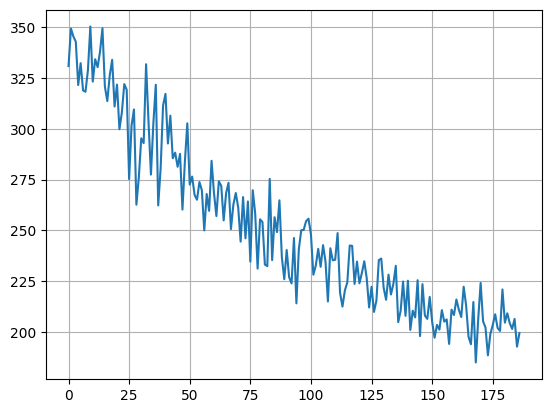

In [386]:
plt.plot(loss_vals[13:])
plt.grid()

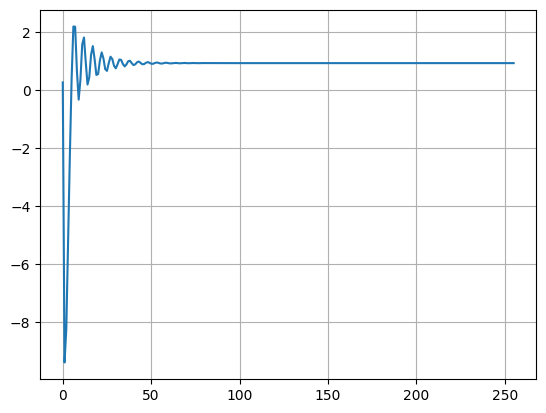

In [387]:
plt.plot(epoch_states[-1][0,:,2])
plt.grid()

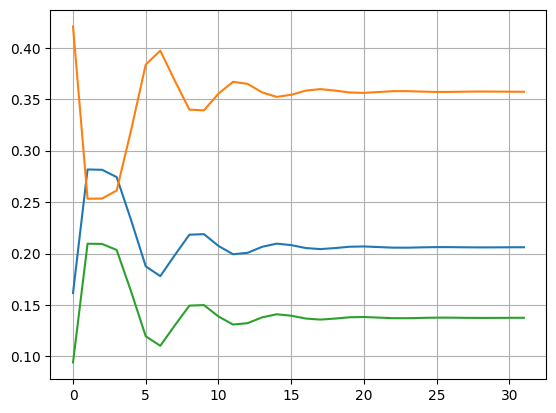

In [381]:
plt.plot(epoch_actions[-1][0,:,:])
plt.grid()

In [ ]:
# def update_gen(sys_desc: str, params_desc: str, action_desc: str, exclude_desc: str) -> str:

#     eqs = parse_expr(', '.join(sys_desc.split('\n')[1:-1]), evaluate=False)

#     variables = sorted_sym_set(set.union(*(eq.free_symbols for eq in eqs)))
#     param_vars = sorted_sym_set(parse_expr(params_desc))
#     action_vars = sorted_sym_set(parse_expr(action_desc))
#     exclude_vars = sorted_sym_set(parse_expr(exclude_desc))
#     prev_vars = sorted_sym_set(filter(lambda v: "_prev" in v.name, variables))
#     state_vars = sorted_sym_set(variables ^ (param_vars | action_vars | prev_vars))

#     print("n_vars", len(state_vars))
#     print("n_eqs", len(eqs))
    
#     print('solve')
#     print(state_vars)
#     sys = sympy.solve(eqs, state_vars, simplify=False)
#     if type(sys) == list:
#         assert len(sys) == 1, str(len(sys))
#         sys = sys[0]

#     sys = {sym: formula for sym, formula in sys.items() if sym not in exclude_vars}
#     print("state_vars", state_vars)
#     print("exclude_vars", exclude_vars)
#     state_vars ^= exclude_vars
#     print("new state_vars", state_vars)


#     keys = sys.keys()
#     print('cse')
#     tmp, sys = sympy.cse(sys.values(), order='none')
#     sys = zip(keys, sys)

#     code = "@jit\ndef update(state: jnp.ndarray, action: jnp.ndarray, params: jnp.ndarray):\n"
#     code += "\t" + ", ".join(map(lambda s: f"{str(s)}_prev", state_vars)) + ", = state.T\n"
#     code += "\t" + str(action_vars)[1:-1] + ", = action.T\n"
#     code += "\t" + str(param_vars)[1:-1] + ", = params\n\n"

#     for a in (tmp, sys):
#         for l, r in a:
#             code += "\t" + f"{pycode(l)} = {pycode(r)}\n"
#         code += '\n'
#     code += "\t" + f"return jnp.array([{str(state_vars)[1:-1]}]).T\n"

#     return code

# def stable_state_gen(sys_desc: str, params_desc: str, action_desc: str, exclude_desc: str) -> str:

#     sys_desc = sys_desc.replace("_prev", "")
#     eqs = parse_expr(', '.join(sys_desc.split('\n'))[2:], evaluate=False)

#     variables = sorted_sym_set(set.union(*(eq.free_symbols for eq in eqs)))
#     param_vars = sorted_sym_set(parse_expr(params_desc))
#     exclude_vars = sorted_sym_set(parse_expr(exclude_desc))
#     action_vars = sorted_sym_set(parse_expr(action_desc))
#     state_vars = sorted_sym_set(variables ^ (param_vars | action_vars))

#     n_free_vars = max(0, len(state_vars) - len(eqs))
#     free_vars = sorted_sym_set(list(state_vars)[:n_free_vars])
#     derivable_vars = sorted_sym_set(list(state_vars)[n_free_vars:])

#     sys = sympy.solve(eqs, derivable_vars)
#     if type(sys) == list:
#         assert len(sys) == 1
#         sys = sys[0]
    
#     sys = {sym: formula for sym, formula in sys.items() if sym not in exclude_vars}
#     state_vars ^= exclude_vars

#     free_vars = sorted_sym_set(free_vars | (set(sys.keys()) ^ state_vars))

#     keys = sys.keys()
#     tmp, sys = sympy.cse(sys.values(), order='none')
#     sys = zip(keys, sys)    

#     code = "@partial(jit, static_argnames=['n_states'])\ndef sample_stable_state(action: jnp.ndarray, params: jnp.ndarray, n_states: int, seed: jnp.array):\n"
#     code += "\t" + str(action_vars)[1:-1] + ", = action.T\n"
#     code += "\t" + str(param_vars)[1:-1] + ", = params\n\n"
#     code += "\t" + str(free_vars)[1:-1] + f", = jax.random.uniform(seed, ({len(free_vars)}, n_states), minval=0.0, maxval=1.0)\n\n"

#     for a in (tmp, sys):
#         for l, r in a:
#             code += "\t" + f"{pycode(l)} = {pycode(r)}\n"
#         code += '\n'
#     code += "\t" + f"return jnp.array([{str(state_vars)[1:-1]}]).T\n"

#     return code